In [15]:
import re, json, glob, csv, sys, os, warnings
import pandas as pd
import numpy as np
import itertools as iter
import networkx as nx
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter
import requests

In [2]:
# Import project-specific functions. 
# Python files (.py) have to be in same folder to work.
lib_path = os.path.abspath(os.path.dirname('JQA_XML_parser.py'))
sys.path.append(lib_path)


In [3]:
files = []
for dirpath, dirnames, filenames in os.walk("JQA-XML"):
    for filename in [f for f in filenames if f.endswith(".xml")]:
        print (os.path.join(dirpath, filename))
        files.append(os.path.join(dirpath, filename))

JQA-XML/1808/JQADiaries-v27-1808-08-p364.xml
JQA-XML/1808/JQADiaries-v27-1808-06-p357.xml
JQA-XML/1808/JQADiaries-v27-1808-12-p379.xml
JQA-XML/1808/JQADiaries-v27-1808-02-p335.xml
JQA-XML/1808/JQADiaries-v27-1808-04-p347.xml
JQA-XML/1808/JQADiaries-v27-1808-05-p353.xml
JQA-XML/1808/JQADiaries-v27-1808-11-p375.xml
JQA-XML/1808/JQADiaries-v27-1808-01-p329.xml
JQA-XML/1808/JQADiaries-v27-1808-07-p360.xml
JQA-XML/1808/JQADiaries-v27-1808-09-p368.xml
JQA-XML/1808/JQADiaries-v27-1808-03-p341.xml
JQA-XML/1808/JQADiaries-v27-1808-10-p371.xml
JQA-XML/1837/JQADiaries-v48-1837-05-p653.xml
JQA-XML/1837/JQADiaries-v41-1837-01-p034.xml
JQA-XML/1837/JQADiaries-v33-1837-04-p231.xml
JQA-XML/1837/JQADiaries-v48-1837-02-p792.xml
JQA-XML/1837/JQADiaries-v33-1837-11-p373.xml
JQA-XML/1837/JQADiaries-v48-1837-07-p673.xml
JQA-XML/1837/JQADiaries-v48-1837-06-p659.xml
JQA-XML/1837/JQADiaries-v50-1837-03-p526.xml
JQA-XML/1837/JQADiaries-v48-1837-01-p779.xml
JQA-XML/1837/JQADiaries-v33-1837-05-p266.xml
JQA-XML/18

In [7]:
files = files[:100]

In [8]:
from JQA_XML_parser import *

# Build dataframe from XML files.
# build_dataframe() called from Correspondence_XML_parser
df = build_dataframe(files)

# Unnest subject headings. 
df['people'] = df['people'].str.split(r',|;')
df = df.explode('people')

# Remove leading and trailing whitespace.
df['people'] = df['people'].str.strip()

# Remove rows with empty values.
df.replace('', np.nan, inplace = True)
df.dropna(inplace = True)

# # Convert to datetime and extract year.
# df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# df['year'] = df['date'].dt.year

# # Chart distribution of weights.
# sns.histplot(data = df, x = 'year')

# plt.show()

df.head(3)

,file,entry,date,people,subjects,text
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,courtdegebelin-antoine,Recreation,"1. Bathed with George this morning, at the pla..."
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,gregory-george,Recreation,"1. Bathed with George this morning, at the pla..."
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,rousseau-jean,Recreation,"1. Bathed with George this morning, at the pla..."


In [34]:
# df.loc[df['date'] == '1837-03']
df

,file,entry,date,people,subjects,text
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,courtdegebelin-antoine,Recreation,"1. Bathed with George this morning, at the pla..."
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,gregory-george,Recreation,"1. Bathed with George this morning, at the pla..."
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,rousseau-jean,Recreation,"1. Bathed with George this morning, at the pla..."
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,adams-louisa-catherine,Recreation,"1. Bathed with George this morning, at the pla..."
0,"('JQADiaries-v27-1808-08-p364.xml',)",jqadiaries-v27-1808-08-01,1808-08-01,smith-catherine-johnson,Recreation,"1. Bathed with George this morning, at the pla..."
...,...,...,...,...,...,...
2797,"('JQADiaries-v33-1838-06-p507.xml',)",jqadiaries-v33-1838-06-28,1838-06-28,adams-georgeanna,"Texas Annexation (1845) ,Smithsonian Institution",28. IV. Thursday. Meeting of the Committee of...
2797,"('JQADiaries-v33-1838-06-p507.xml',)",jqadiaries-v33-1838-06-28,1838-06-28,rencher-abraham,"Texas Annexation (1845) ,Smithsonian Institution",28. IV. Thursday. Meeting of the Committee of...
2797,"('JQADiaries-v33-1838-06-p507.xml',)",jqadiaries-v33-1838-06-28,1838-06-28,vanburen-martin,"Texas Annexation (1845) ,Smithsonian Institution",28. IV. Thursday. Meeting of the Committee of...
2797,"('JQADiaries-v33-1838-06-p507.xml',)",jqadiaries-v33-1838-06-28,1838-06-28,fletcher-isaac,"Texas Annexation (1845) ,Smithsonian Institution",28. IV. Thursday. Meeting of the Committee of...


In [37]:
df['people'].nunique()

4069

In [18]:
response = requests.get("https://primarysourcecoop.org/mhs-api/ext/names?huscs=adams-john")
response.json()



{'data': {'adams-john': {'family_name': 'Adams',
   'given_name': 'John',
   'maiden_name': '',
   'middle_name': '',
   'suffix': '',
   'title': '',
   'professions': 'Delegates, U.S. Continental Congress; Diplomats; Lawyers; Presidents; Vice presidents',
   'variants': 'JA',
   'name_key': 'adams-john',
   'date_of_birth': '1735',
   'birth_ca': '0',
   'birth_era': 'ce',
   'date_of_death': '1826',
   'death_ca': '0',
   'death_era': 'ce',
   'identifier': 'jqa: CJT',
   'verified': 'KNB 10/26/2018',
   'sort_birth': 'CE17350000',
   'sort_name': 'AdamsJohnJA',
   'created_at': '2021-11-16 15:13:10',
   'updated_at': '2023-01-19 15:01:38'}},
 'errors': [],
 'messages': [],
 'html': ''}

In [28]:
response.json()['data']['adams-john']['family_name'] + response.json()['data']['adams-john']['given_name']

'AdamsJohn'

In [35]:
with open('idtoname.json') as f:
    d = json.load(f)
names = []
for index, row in df.head(5).iterrows():
    if row['people'] in d:
        print('found')
        names.append(d[row['people']]['given_name'] + " " + d[row['people']]['family_name'])
    else:
        request_url = "https://primarysourcecoop.org/mhs-api/ext/names?huscs={}".format(row['people'])
        response = requests.get(request_url)
        names.append(response.json()['data'][row['people']]['given_name'] + " " + response.json()['data'][row['people']]['family_name'])
        d[row['people']] = response.json()['data'][row['people']]
        with open('idtoname.json', 'w') as f:
            json.dump(d, f)


found
found
found
found
found


In [36]:
names

['Antoine Court de Gebelin',
 'George Gregory',
 'Jean Rousseau',
 'Louisa Adams',
 'Catherine Smith']

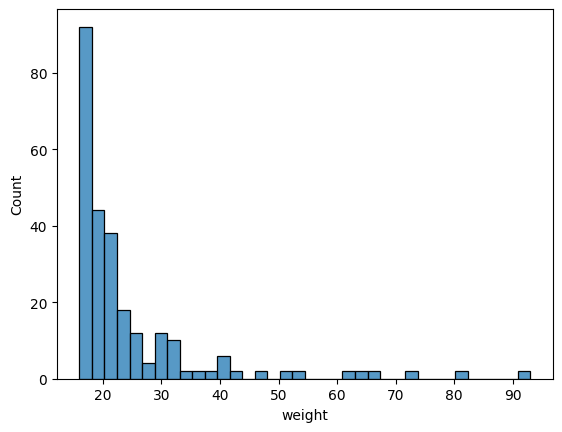

CPU times: user 7.88 s, sys: 130 ms, total: 8.01 s
Wall time: 7.96 s


In [10]:
%%time

# Filter dates by distribution.
df = df.query('(people != "u") & (people != "source")') 
    #.query('(date < "1800-01-01") | (date >= "1830-01-01")')

# Create adjacency matrix.
adj = pd.crosstab(df['entry'], df['people'])

# Convert entry-person matrix into an adjacency matrix of persons.
adj = adj.T.dot(adj)

# Change same-same connections to zero.
np.fill_diagonal(adj.values, 0)

# # Simple correlation matrix from dataframe.
# adj = adj.corr()

adj['source'] = adj.index

df_graph = pd.melt(adj, id_vars = 'source', var_name = 'target', value_name = 'weight') \
    .query('(source != target) & (weight > 15)') # 20 is good

# Chart distribution of weights.
sns.histplot(data = df_graph, x = 'weight')

plt.show()

In [11]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(df_graph, 'source', 'target', 'weight')

# Add nodes.
nodes = list( dict.fromkeys( df_graph['source'].values.tolist() + df_graph['target'].values.tolist() ))
nodes = pd.DataFrame(nodes, columns = ['source'])
G.add_nodes_from(nodes)

print (G)

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

# Sort nodes by degree and print top results.
sorted_degree = sorted(dict(G.degree(G.nodes())).items(),
                       key = itemgetter(1), reverse = True)

print ("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print (f'\t{d}')

# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")


# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find centrality measures. 
betweenness_dict = nx.betweenness_centrality(subgraph) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(subgraph) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(subgraph)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(subgraph, betweenness_dict, 'betweenness')
nx.set_node_attributes(subgraph, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(subgraph, degree_cent_dict, 'degree_cent')

# Find communities. naive_greedy_modularity_communities
communities = community.naive_greedy_modularity_communities(subgraph)
# communities = community.k_clique_communities(subgraph, 5)
# communities = community.greedy_modularity_communities(subgraph)
# communities = community.kernighan_lin_bisection(subgraph)

# Create a dictionary that maps nodes to their community.
modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
# Add modularity information to graph object.
nx.set_node_attributes(subgraph, modularity_dict, 'modularity')

Graph with 72 nodes and 131 edges
Top 10 nodes by degree:
	('adams-abigail4', 18)
	('vanburen-martin', 18)
	('cambreleng-churchill', 18)
	('hellen-mary', 17)
	('polk-james', 17)
	('adams-charles2', 13)
	('adams-georgeanna', 8)
	('adams-louisa-catherine', 8)
	('adams-elizabeth', 7)
	('adams-mary4', 7)
Network density: 0.051
Is the network connected? False
Triadic closure: 0.321

Network diameter of the largest component: 6.000
CPU times: user 13.1 s, sys: 13.7 ms, total: 13.1 s
Wall time: 13.1 s


In [57]:
%%time

# Convert graph object into a dictionary.
data = json_graph.node_link_data(subgraph)

with open('idtoname.json') as f:
    d = json.load(f)
for node in data['nodes']:
    if node['id'] in d:
        print('found')
        node['name'] = (d[node['id']]['given_name'] + " " + d[node['id']]['family_name'])
    else:
        request_url = "https://primarysourcecoop.org/mhs-api/ext/names?huscs={}".format(node['id'])
        response = requests.get(request_url)
        node['name'] = response.json()['data'][node['id']]['given_name'] + " " + response.json()['data'][node['id']]['family_name']
        d[node['id']] = response.json()['data'][node['id']]
        with open('idtoname.json', 'w') as f:
            json.dump(d, f)

# # Serialize dictionary with json.
# class NPEncoder(JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return JSONEncoder.default(self, obj)
    
# data_json = json.dumps(data, cls=NPEncoder)

with open("jqa_coRef-network.json", "w") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
CPU times: user 6.2 ms, sys: 2.97 ms, total: 9.17 ms
Wall time: 8.37 ms


In [53]:
data['nodes']

[{'degree': 18,
  'betweenness': 0.25656382335148203,
  'eigenvector': 0.33798531433313755,
  'degree_cent': 0.3103448275862069,
  'modularity': 1,
  'id': 'adams-abigail4'},
 {'degree': 2,
  'betweenness': 0.0,
  'eigenvector': 0.0641646039398091,
  'degree_cent': 0.034482758620689655,
  'modularity': 1,
  'id': 'adams-abigail2'},
 {'degree': 7,
  'betweenness': 0.005495059487799959,
  'eigenvector': 0.1966478954885327,
  'degree_cent': 0.12068965517241378,
  'modularity': 1,
  'id': 'adams-elizabeth'},
 {'degree': 4,
  'betweenness': 0.0,
  'eigenvector': 0.1398941799939531,
  'degree_cent': 0.06896551724137931,
  'modularity': 1,
  'id': 'adams-ann'},
 {'degree': 13,
  'betweenness': 0.05576729179270013,
  'eigenvector': 0.2757798352938984,
  'degree_cent': 0.22413793103448276,
  'modularity': 1,
  'id': 'adams-charles2'},
 {'degree': 8,
  'betweenness': 0.02057874571486187,
  'eigenvector': 0.24932575431715281,
  'degree_cent': 0.13793103448275862,
  'modularity': 1,
  'id': 'adams

In [48]:
for node in data['nodes']:
    if node['id'] in d:
        print('found')
        node['name'] = (d[node['id']]['given_name'] + " " + d[node['id']]['family_name'])
    else:
        request_url = "https://primarysourcecoop.org/mhs-api/ext/names?huscs={}".format(node['id'])
        response = requests.get(request_url)
        node['name'] = response.json()['data'][node['id']]['given_name'] + " " + response.json()['data'][node['id']]['family_name']
        d[node['id']] = response.json()['data'][node['id']]
        with open('idtoname.json', 'w') as f:
            json.dump(d, f)

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


In [42]:
names

['Antoine Court de Gebelin',
 'George Gregory',
 'Jean Rousseau',
 'Louisa Adams',
 'Catherine Smith',
 'Abigail Adams',
 'Abigail Angier',
 'Elizabeth Adams',
 'Ann Adams',
 'Charles Adams',
 'Georgeanna (Fanny) Adams',
 'John Adams',
 'Louisa Adams',
 'Louisa Adams',
 'Mary Adams',
 'George Beale',
 'Marcus Cicero',
 'Ezekiel Greenleaf',
 'Mary Adams',
 'Amos Holbrook',
 'William Lunt',
 'Louisa Smith',
 'Martin Van Buren',
 'Peter Whitney',
 'John Adams',
 'Isaac Adams',
 'Isaac Adams',
 'William Hawley',
 'Mark Antony',
 'Titus Atticus',
 'Churchill Cambreleng',
 'John Bell',
 'James Polk',
 'Richard Biddle',
 'George Briggs',
 'Caleb Cushing',
 'Levi Lincoln',
 'Robert Buchanan',
 'Julius Caesar',
 'Andrew Jackson',
 'John Calhoun',
 'William Dawson',
 'Charles Haynes (Haines)',
 'Benjamin Howard',
 'John Reed',
 'John Robertson',
 'John Sergeant',
 'Francis Thomas',
 'Waddy Thompson',
 'Joseph Underwood',
 'Elisha Whittlesey',
 'Henry Wise',
 'Levi Woodbury',
 'Samuel Cushman',
 

In [47]:
data

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'degree': 18,
   'betweenness': 0.25656382335148203,
   'eigenvector': 0.33798531433313755,
   'degree_cent': 0.3103448275862069,
   'modularity': 1,
   'id': 'adams-abigail4',
   'name': 'Abigail Adams'},
  {'degree': 2,
   'betweenness': 0.0,
   'eigenvector': 0.0641646039398091,
   'degree_cent': 0.034482758620689655,
   'modularity': 1,
   'id': 'adams-abigail2',
   'name': 'Abigail Angier'},
  {'degree': 7,
   'betweenness': 0.005495059487799959,
   'eigenvector': 0.1966478954885327,
   'degree_cent': 0.12068965517241378,
   'modularity': 1,
   'id': 'adams-elizabeth',
   'name': 'Elizabeth Adams'},
  {'degree': 4,
   'betweenness': 0.0,
   'eigenvector': 0.1398941799939531,
   'degree_cent': 0.06896551724137931,
   'modularity': 1,
   'id': 'adams-ann',
   'name': 'Ann Adams'},
  {'degree': 13,
   'betweenness': 0.05576729179270013,
   'eigenvector': 0.2757798352938984,
   'degree_cent': 0.22413793103448276,
   '

In [49]:
with open('idtoname.json', 'w') as f:
            json.dump(d, f)

In [52]:
data

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'degree': 18,
   'betweenness': 0.25656382335148203,
   'eigenvector': 0.33798531433313755,
   'degree_cent': 0.3103448275862069,
   'modularity': 1,
   'id': 'adams-abigail4'},
  {'degree': 2,
   'betweenness': 0.0,
   'eigenvector': 0.0641646039398091,
   'degree_cent': 0.034482758620689655,
   'modularity': 1,
   'id': 'adams-abigail2'},
  {'degree': 7,
   'betweenness': 0.005495059487799959,
   'eigenvector': 0.1966478954885327,
   'degree_cent': 0.12068965517241378,
   'modularity': 1,
   'id': 'adams-elizabeth'},
  {'degree': 4,
   'betweenness': 0.0,
   'eigenvector': 0.1398941799939531,
   'degree_cent': 0.06896551724137931,
   'modularity': 1,
   'id': 'adams-ann'},
  {'degree': 13,
   'betweenness': 0.05576729179270013,
   'eigenvector': 0.2757798352938984,
   'degree_cent': 0.22413793103448276,
   'modularity': 1,
   'id': 'adams-charles2'},
  {'degree': 8,
   'betweenness': 0.02057874571486187,
   'eigenvec